In [1]:
import functools
import glob
import os

In [2]:
import coord
import fitsio
import galsim
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import h5py
from sklearn.neighbors import BallTree
from scipy.stats import chi2 as chi2_dist

In [3]:
import util

In [4]:
os.environ["IMSIM_DATA"] = "/global/cfs/cdirs/desbalro"
os.environ["PATH"] += ":/global/common/software/nersc9/texlive/2024/bin/x86_64-linux"

In [5]:
shear_steps = [
    'g1_slice=-0.02__g2_slice=0.00__g1_other=0.00__g2_other=0.00__zlow=0.0__zhigh=6.0',
    'g1_slice=0.02__g2_slice=0.00__g1_other=-0.02__g2_other=0.00__zlow=0.6__zhigh=0.9',
    'g1_slice=0.02__g2_slice=0.00__g1_other=-0.02__g2_other=0.00__zlow=1.8__zhigh=2.1',
    'g1_slice=0.02__g2_slice=0.00__g1_other=0.00__g2_other=0.00__zlow=0.0__zhigh=6.0',
    'g1_slice=0.02__g2_slice=0.00__g1_other=-0.02__g2_other=0.00__zlow=0.9__zhigh=1.2',
    'g1_slice=0.02__g2_slice=0.00__g1_other=-0.02__g2_other=0.00__zlow=2.1__zhigh=2.4',
    'g1_slice=0.02__g2_slice=0.00__g1_other=-0.02__g2_other=0.00__zlow=0.0__zhigh=0.3',
    'g1_slice=0.02__g2_slice=0.00__g1_other=-0.02__g2_other=0.00__zlow=1.2__zhigh=1.5',
    'g1_slice=0.02__g2_slice=0.00__g1_other=-0.02__g2_other=0.00__zlow=2.4__zhigh=2.7',
    'g1_slice=0.02__g2_slice=0.00__g1_other=-0.02__g2_other=0.00__zlow=0.3__zhigh=0.6',
    'g1_slice=0.02__g2_slice=0.00__g1_other=-0.02__g2_other=0.00__zlow=1.5__zhigh=1.8',
    'g1_slice=0.02__g2_slice=0.00__g1_other=-0.02__g2_other=0.00__zlow=2.7__zhigh=6.0',
]

In [6]:
ALPHA = {
    -1: (0.0, 6.0),
    0: (0.0, 0.3),
    1: (0.3, 0.6),
    2: (0.6, 0.9),
    3: (0.9, 1.2),
    4: (1.2, 1.5),
    5: (1.5, 1.8),
    6: (1.8, 2.1),
    7: (2.1, 2.4),
    8: (2.4, 2.7),
    9: (2.7, 6.0),
}
ALPHA_BINS = [-1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

In [7]:
truth_base = "/global/cfs/cdirs/desbalro/cosmos_simcat/"

In [8]:
truth_catalogs = {}
for _truth_file in glob.glob(f"{truth_base}/*.fits"):
    _tilename = str.encode(_truth_file.split("/")[-1].split("_")[3])
    truth_catalogs[_tilename] = _truth_file

In [9]:
star_base = "/global/cfs/cdirs/desbalro/starsim/catalogs/merged_y6/"

In [10]:
star_catalogs = {}
for _star_file in glob.glob(f"{star_base}/*.fits"):
    _tilename = str.encode(_star_file.split("/")[-1].split(".")[0])
    star_catalogs[_tilename] = _star_file

In [176]:
shear_step = shear_steps[0]
alpha = -1

In [177]:
imsim_base = "/global/cfs/cdirs/des/y6-image-sims/fiducial-400/"
imsim_catalogs = {
    shear_step: os.path.join(
        imsim_base,
        shear_step,
        "metadetect_cutsv6_all.h5",
    )
    for shear_step in shear_steps
}
imsim_hf = {
    shear_step: h5py.File(imsim_catalog, mode="r")
    for shear_step, imsim_catalog in imsim_catalogs.items()
}

In [178]:
tilenames = functools.reduce(
    np.intersect1d,
    [
        np.unique(hf["mdet"]["noshear"]["tilename"][:])
        for hf in imsim_hf.values()
    ],
)
ntiles = len(tilenames)

In [202]:
# tilename = tilenames[0]
# tilename_str = tilename.astype(str)
tilename = b'DES2359+0001'
tilename_str = "DES2359+0001"

In [203]:
truth_table = fitsio.FITS(truth_catalogs[tilename])[1]

In [204]:
wcs = util.load_wcs(tilename_str)

In [205]:
print(f"Loading {tilename_str} at {wcs.center.ra.deg, wcs.center.dec.deg}")

Loading DES2359+0001 at (359.952781, 0.016667)


In [206]:
in_tile = imsim_hf[shear_step]["mdet"]["noshear"]["tilename"][:] == tilename

In [207]:
observed_table = {
    key: imsim_hf[shear_step]["mdet"]["noshear"][key][in_tile][:]
    for key in imsim_hf[shear_step]["mdet"]["noshear"].keys()
}

In [208]:
# xyz = [
#     (galsim.PositionD(x, y), z)
#     for (x, y, z) in truth_table[["x_sim", "y_sim", "photoz"]][:]
# ]

In [209]:
# # https://github.com/des-science/montara/blob/main/montara/z_slice_shear.py#L5-L25
# shear_slice = galsim.Shear(g1=0.02, g2=0.00)  # FIXME depends on shear_step
# shear_other = galsim.Shear(g1=-0.02, g2=0.00)  # FIXME depends on shear_step
# sheared_xy = [
#     position.shear(shear_slice) if (redshift > ALPHA[alpha][0]) & (redshift <= ALPHA[alpha][1])
#     else position.shear(shear_other)
#     for position, redshift in xyz
# ]

In [210]:
# sheared_uv = [
#     wcs.toWorld(pos)
#     for pos in sheared_xy
# ]

In [211]:
# sheared_radec = [
#     (uv.ra.deg, uv.dec.deg)
#     for uv in sheared_uv
# ]

In [212]:
# world_pos = [
#     galsim.PositionD(x, y)
#     for (x, y) in truth_table[["ra_sim", "dec_sim"]][:]
# ]

In [213]:
truth_table[["ra_sim", "dec_sim", "photoz"]][:]

array([(1.4878    , 360.33794512, -0.37676357),
       (1.19570005, 360.52316884, -0.28039591),
       (1.24489999, 360.14812852,  0.22713659), ...,
       (3.70079994, 360.49652846, -0.27444724),
       (2.04480004, 360.26109041,  0.04894302),
       (0.87510002, 360.23351359,  0.36992477)],
      dtype=[('photoz', '>f8'), ('ra_sim', '>f8'), ('dec_sim', '>f8')])

In [214]:
# # https://github.com/des-science/montara/blob/main/montara/z_slice_shear.py#L5-L25

# https://github.com/des-science/montara/blob/main/montara/coadd_mixed_scene.py#L76-L94

# shear_slice = galsim.Shear(g1=0.02, g2=0.00)  # FIXME depends on shear_step
# shear_other = galsim.Shear(g1=-0.02, g2=0.00)  # FIXME depends on shear_step
shear_slice = galsim.Shear(g1=-0.02, g2=0.00)  # FIXME depends on shear_step
shear_other = galsim.Shear(g1=0.00, g2=0.00) 

sheared_radec = []
for ra, dec, redshift in zip(truth_table["ra_sim"][:], truth_table["dec_sim"][:], truth_table["photoz"][:]):
    if (redshift > ALPHA[alpha][0]) & (redshift <= ALPHA[alpha][1]):
        _shear = shear_slice
    else:
        _shear = shear_other
        
    world_pos = coord.CelestialCoord(ra=ra * galsim.degrees, dec=dec * galsim.degrees)
    u, v = wcs.center.project(world_pos, projection='gnomonic')
    pos = galsim.PositionD(u.rad, v.rad)
    
    sheared_pos = pos.shear(_shear)
    u2 = sheared_pos.x * coord.radians
    v2 = sheared_pos.y * coord.radians
    sheared_world_pos = wcs.center.deproject(u2, v2, projection='gnomonic')
    # sheared_image_pos = wcs.toImage(sheared_world_pos)
    
    sheared_ra = sheared_world_pos.ra.deg
    sheared_dec = sheared_world_pos.dec.deg

    sheared_radec.append((sheared_ra, sheared_dec))

In [215]:
truth_points = np.deg2rad(np.array(sheared_radec))

In [216]:
observed_points = np.deg2rad(
    np.array([
        observed_table["ra"],
        observed_table["dec"],
    ]).T
)

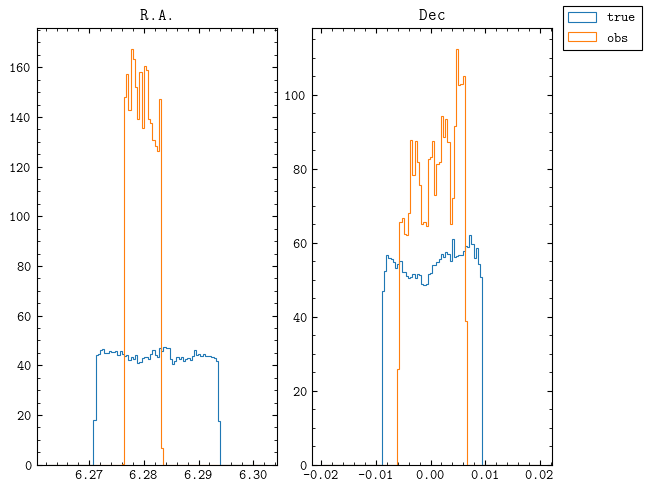

In [217]:
fig, axs = plt.subplots(1, 2, constrained_layout=True)

nbins = 100
# edges = np.linspace(-2 * np.pi, 2 * np.pi, 20)
edges = (
    np.linspace(
        wcs.center.ra.rad - 2e-2,
        wcs.center.ra.rad + 2e-2,
        nbins + 1,
    ),
   np.linspace(
        wcs.center.dec.rad - 2e-2,
        wcs.center.dec.rad + 2e-2,
        nbins + 1,
    )
)

axs[0].hist(truth_points[:, 0], bins=edges[0], density=True, histtype="step",)
axs[0].hist(observed_points[:, 0], bins=edges[0], density=True, histtype="step")
axs[0].set_title("R.A.")

axs[1].hist(truth_points[:, 1], bins=edges[1], density=True, histtype="step", label="true")
axs[1].hist(observed_points[:, 1], bins=edges[1], density=True, histtype="step", label="obs")
axs[1].set_title("Dec")

fig.legend(loc="outside right upper")

plt.show()

# note: we epxect the truth points to cover a broader distance because additional cuts are applied to the truth
#       catalog before simulating, including subselecting a region in space

In [218]:
bt = BallTree(
    truth_points,
    metric="haversine",
)

In [219]:
query_radius_arcsec = 1
# query_radius = 1e-5
# query_radius = 5e-6
query_radius = np.deg2rad(query_radius_arcsec / 60 / 60)
print(query_radius)

4.84813681109536e-06


In [220]:
indices, distances = bt.query_radius(
    observed_points,
    r=query_radius,
    return_distance=True,
    sort_results=True,
)

In [221]:
h = np.bincount(list(map(len, indices)))
x = range(len(h))
print(x, h)

range(0, 4) [   65 11738  1021    24]


In [222]:
h[0] / sum(h)

0.005059153175591532

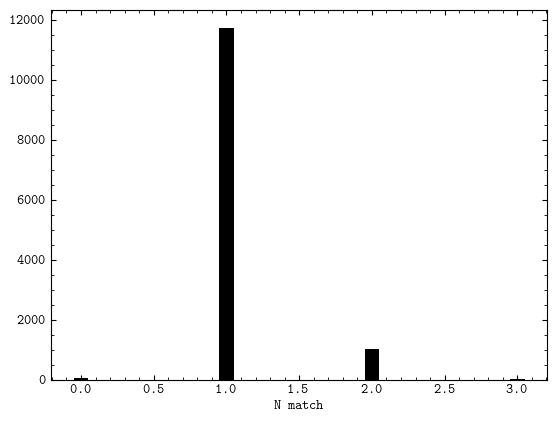

In [223]:
plt.bar(
    x, h,
    width=0.1,
    fc="k",
)
plt.xlabel("N match")
plt.show()

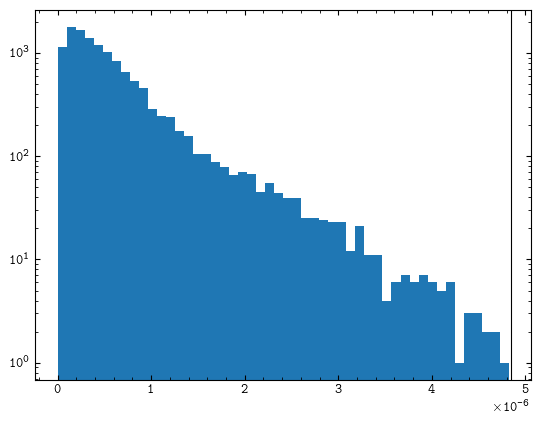

In [224]:
plt.hist(
    list(map(min, filter(lambda ds: len(ds) > 0, distances))),
    bins=50
)
plt.axvline(query_radius)
plt.yscale("log")
plt.show()

In [225]:
_i = 100
# observed_points[indices[_i]], truth_points[_i]
truth_points[indices[_i]], observed_points[_i]

(array([[ 6.28776522e+00, -5.73308127e-03]]),
 array([ 0.00458038, -0.00573295]))

In [226]:
bands = ["g", "r", "i", "z"]

In [227]:
_min_chi2 = np.array([
    np.sort(
        np.sum(
            [
                np.square(
                    np.divide(
                        np.subtract(
                            observed_table[f"pgauss_band_flux_{band}"][_i],
                            truth_table[f"flux_{band}"][indices[_i]]
                        ),
                        observed_table[f"pgauss_band_flux_err_{band}"][_i]
                    )
                )
                for band in bands
            ],
            axis=0
        )
    )[0] if len(indices[_i]) > 0 else 0
    for _i in range(len(observed_points))
])

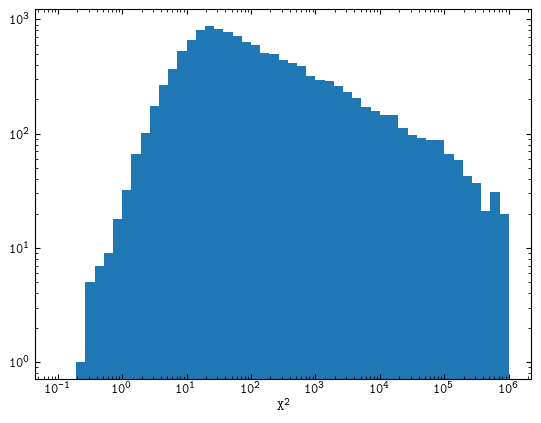

In [228]:
plt.hist(
    _min_chi2,
    bins=np.geomspace(1e-1, 1e6),
)
plt.xlabel("$\\Chi^2$")
plt.yscale("log")
plt.xscale("log")
plt.show()

In [229]:
# _chi2 = [
#     np.square(
#         np.divide(
#             np.subtract(
#                 observed_table[f"pgauss_band_flux_{band}"][ind.reshape(-1)],
#                 truth_table[f"flux_{band}"][:]
#             ),
#             observed_table[f"pgauss_band_flux_err_{band}"][ind.reshape(-1)]
#         )
#     )
#     for band in bands
# ]
# _chi2 = [
#     [
#         np.square(
#             np.divide(
#                 np.subtract(
#                     observed_table[f"pgauss_band_flux_{band}"][_i],
#                     truth_table[f"flux_{band}"][indices[_i]]
#                 ),
#                 observed_table[f"pgauss_band_flux_err_{band}"][_i]
#             )
#         )
#         for _i in range(len(observed_points))
#     ]
#     for band in bands
# ]
_min_chi2_indices = np.array([
    np.argsort(
        np.sum(
            [
                np.square(
                    np.divide(
                        np.subtract(
                            observed_table[f"pgauss_band_flux_{band}"][_i],
                            truth_table[f"flux_{band}"][indices[_i]]
                        ),
                        observed_table[f"pgauss_band_flux_err_{band}"][_i]
                    )
                )
                for band in bands
            ],
            axis=0
        ) / len(bands)
    )[0] if len(indices[_i]) > 0 else 0
    for _i in range(len(observed_points))
])

# _chi2 = [
#     np.square(
#         np.divide(
#             np.subtract(
#                 observed_table[f"pgauss_band_flux_{band}"][:],
#                 truth_table[f"flux_{band}"][ind.reshape(-1)]
#             ),
#             observed_table[f"pgauss_band_flux_err_{band}"][:]
#         )
#     )
#     for band in bands
# ]
# _min_chi2_indices = np.array([
#     np.argsort(
#         np.sum(
#             [
#                 np.square(
#                     np.divide(
#                         np.subtract(
#                             observed_table[f"pgauss_band_flux_{band}"][indices[_i]],
#                             truth_table[f"flux_{band}"][_i]
#                         ),
#                         observed_table[f"pgauss_band_flux_err_{band}"][indices[_i]]
#                     )
#                 )
#                 for band in bands
#             ],
#             axis=0
#         ) / len(bands)
#     )[0]  if len(indices[_i]) > 0 else 0
#     for _i in range(len(truth_points))
# ])

In [230]:
truth_min_chi2_indices = np.array([
    _i[_ii]
    for (_i, _ii) in zip(indices, _min_chi2_indices) if len(_i) > 0
])
observed_min_chi2_indices = np.array([
    i
    for (i, _i) in enumerate(indices) if len(_i) > 0
])

# observed_min_chi2_indices = np.array([
#     _i[_ii]
#     for (_i, _ii) in zip(indices, _min_chi2_indices) if len(_i) > 0
# ])
# truth_min_chi2_indices = np.array([
#     i
#     for i, (_i, _ii) in enumerate(zip(indices, _min_chi2_indices)) if len(_i) > 0
# ])


# truth_table["flux_r"][_min_chi2_indices]

In [231]:
_idx = np.array([])

In [232]:
_idx_filter = np.isin(
    np.arange(len(indices)),
    truth_min_chi2_indices,
)

In [233]:
truth_min_chi2_indices.shape

(12783,)

In [234]:
truth_table[truth_min_chi2_indices]["photoz"]

array([1.00839996, 1.17739999, 0.15000001, ..., 0.42989999, 0.90200001,
       0.52380002], dtype='>f8')

In [235]:
observed_unmatched_indices = np.setdiff1d(
    np.indices((len(observed_points),)).ravel(),
    observed_min_chi2_indices,
    assume_unique=True
)

In [236]:
truth_unmatched_indices = np.setdiff1d(
    np.indices((len(truth_points),)).ravel(),
    truth_min_chi2_indices,
    assume_unique=True
)

In [237]:
assert np.unique(observed_min_chi2_indices, return_counts=True)[1].max() == 1
# assert np.unique(truth_min_chi2_indices, return_counts=True)[1].max() == 1

In [238]:
catalog_indices = np.indices(
    in_tile.shape,
).ravel()

In [239]:
observed_catalog_indices = catalog_indices[in_tile][observed_min_chi2_indices]

In [240]:
truth_matched = truth_table[truth_min_chi2_indices]

In [241]:
coadd_paths = {}
for band in bands:
    _paths = glob.glob(os.path.join(
        "/pscratch/sd/s/smau/y6-image-sims/fiducial/",
        tilename_str,
        "*",
        shear_step,
        "des-pizza-slices-y6",
        tilename_str,
        f"{tilename_str}_{band}_des-pizza-slices-y6-v15_meds-pizza-slices.fits.fz",
    ))
    _coadd_path = _paths.pop()
    assert len(_paths) == 0
    coadd_paths[band] = _coadd_path

In [242]:
star_table = fitsio.FITS(star_catalogs[tilename])[1]

In [243]:
coadd = util.read_meds(coadd_paths["r"])

reading slices: |####################| 9801/9801 100% [elapsed: 00:30 left: 00:00]


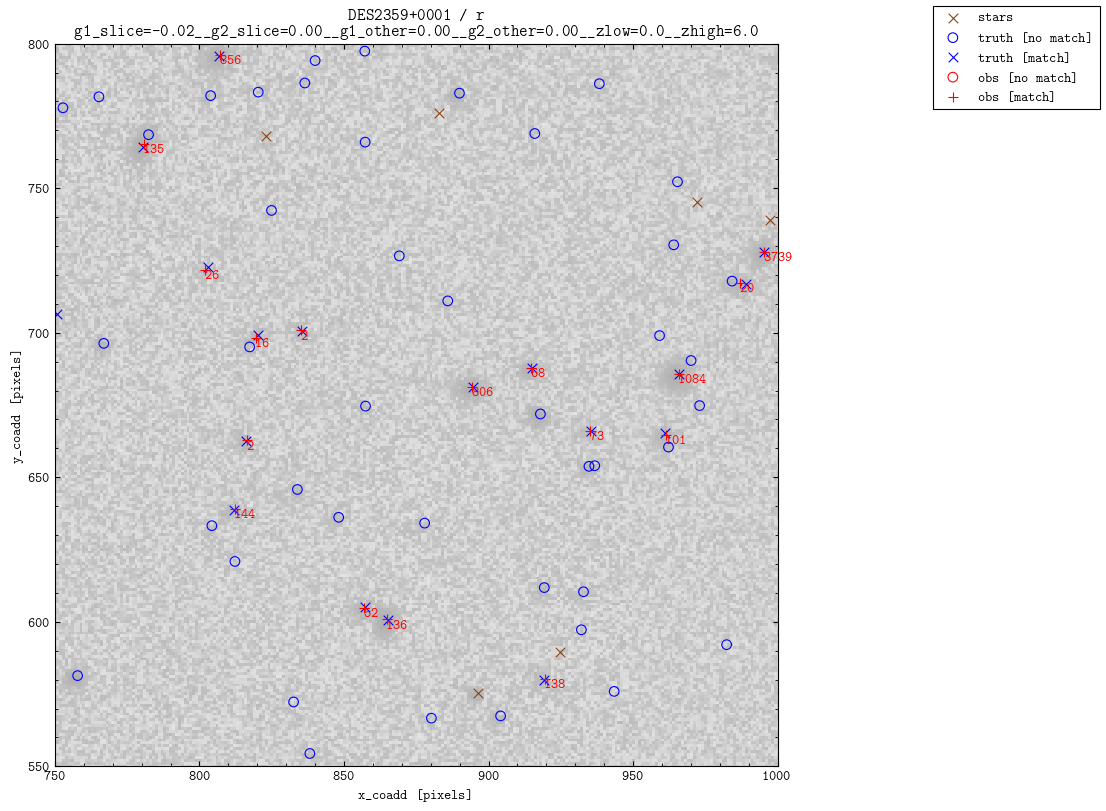

In [244]:
_size = 250
xmin = 750
xmax = xmin + _size
ymin = 550
ymax = ymin + _size

query_radius_pixels = np.rad2deg(query_radius) * 60 * 60 / 0.263

star_x, star_y = wcs.toImage(
    star_table["ra"][:],
    star_table["dec"][:],
    units=galsim.degrees,
)
star_sel = (
    (star_x >= xmin)
    & (star_x < xmax)
    & (star_y >= ymin)
    & (star_y < ymax)
)

true_x, true_y = wcs.toImage(
    truth_points[truth_min_chi2_indices, 0],
    truth_points[truth_min_chi2_indices, 1],
    units=galsim.radians,
)
true_sel = (
    (true_x >= xmin)
    & (true_x < xmax)
    & (true_y >= ymin)
    & (true_y < ymax)
)

all_true_x, all_true_y = wcs.toImage(
    truth_points[truth_unmatched_indices, 0],
    truth_points[truth_unmatched_indices, 1],
    units=galsim.radians,
)
all_true_sel = (
    (all_true_x >= xmin)
    & (all_true_x < xmax)
    & (all_true_y >= ymin)
    & (all_true_y < ymax)
)

all_obs_x, all_obs_y = wcs.toImage(
    observed_points[observed_unmatched_indices, 0],
    observed_points[observed_unmatched_indices, 1],
    units=galsim.radians,
)
all_obs_sel = (
    (all_obs_x >= xmin)
    & (all_obs_x < xmax)
    & (all_obs_y >= ymin)
    & (all_obs_y < ymax)
)

obs_x, obs_y = wcs.toImage(
    observed_points[observed_min_chi2_indices, 0],
    observed_points[observed_min_chi2_indices, 1],
    units=galsim.radians,
)
obs_sel = (
    (obs_x >= xmin)
    & (obs_x < xmax)
    & (obs_y >= ymin)
    & (obs_y < ymax)
)

fig, axs = plt.subplots(1, 1, constrained_layout=True, figsize=(12, 8))

axs.imshow(np.arcsinh(coadd), origin="lower", alpha=0.5)

axs.scatter(
    star_x[star_sel],
    star_y[star_sel],
    s=48,
    c="saddlebrown",
    marker="x",
    label="stars",
)

axs.scatter(
    all_true_x[all_true_sel],
    all_true_y[all_true_sel],
    s=48,
    ec="b",
    fc="none",
    marker="o",
    label="truth [no match]",
)

axs.scatter(
    true_x[true_sel],
    true_y[true_sel],
    s=48,
    c="b",
    marker="x",
    label="truth [match]",
)
# for x, y, mag in zip(true_x[true_sel], true_y[true_sel], truth_table["mag_r"][truth_min_chi2_indices][true_sel]):
#     axs.text(x, y, round(mag, 2), c="r", horizontalalignment="left", verticalalignment="bottom")

axs.scatter(
    all_obs_x[all_obs_sel],
    all_obs_y[all_obs_sel],
    s=48,
    ec="r",
    fc="none",
    marker="o",
    label="obs [no match]",
)

axs.scatter(
    obs_x[obs_sel],
    obs_y[obs_sel],
    s=48,
    c="r",
    marker="+",
    label="obs [match]",
)
# for x, y, _flux in zip(obs_x[obs_sel], obs_y[obs_sel], observed_table["pgauss_band_flux_r"][observed_min_chi2_indices][obs_sel]):
#     # _mag = 30 - 2.5 * np.log10(_flux)
#     # axs.text(x, y, round(_mag, 2), c="b", horizontalalignment="left", verticalalignment="top")
for x, y, c2 in zip(obs_x[obs_sel], obs_y[obs_sel], _min_chi2[observed_min_chi2_indices][obs_sel]):
    # _mag = 30 - 2.5 * np.log10(_flux)
    axs.text(x, y, round(c2), c="r", horizontalalignment="left", verticalalignment="top")
    
# plt.plot(
#     [
#         (xmax + xmin) / 2,
#         (xmax + xmin) / 2 + query_radius_pixels,
#     ],
#     [
#         (ymax + ymin) / 2,
#         (ymax + ymin) / 2,
#     ],
#     c="r",
# )

axs.set_xlim(xmin, xmax)
axs.set_ylim(ymin, ymax)

axs.set_xlabel("x_coadd [pixels]")
axs.set_ylabel("y_coadd [pixels]")
axs.set_title(f"{tilename_str} / r\n{shear_step}")

fig.legend(loc="outside right upper")

plt.show()

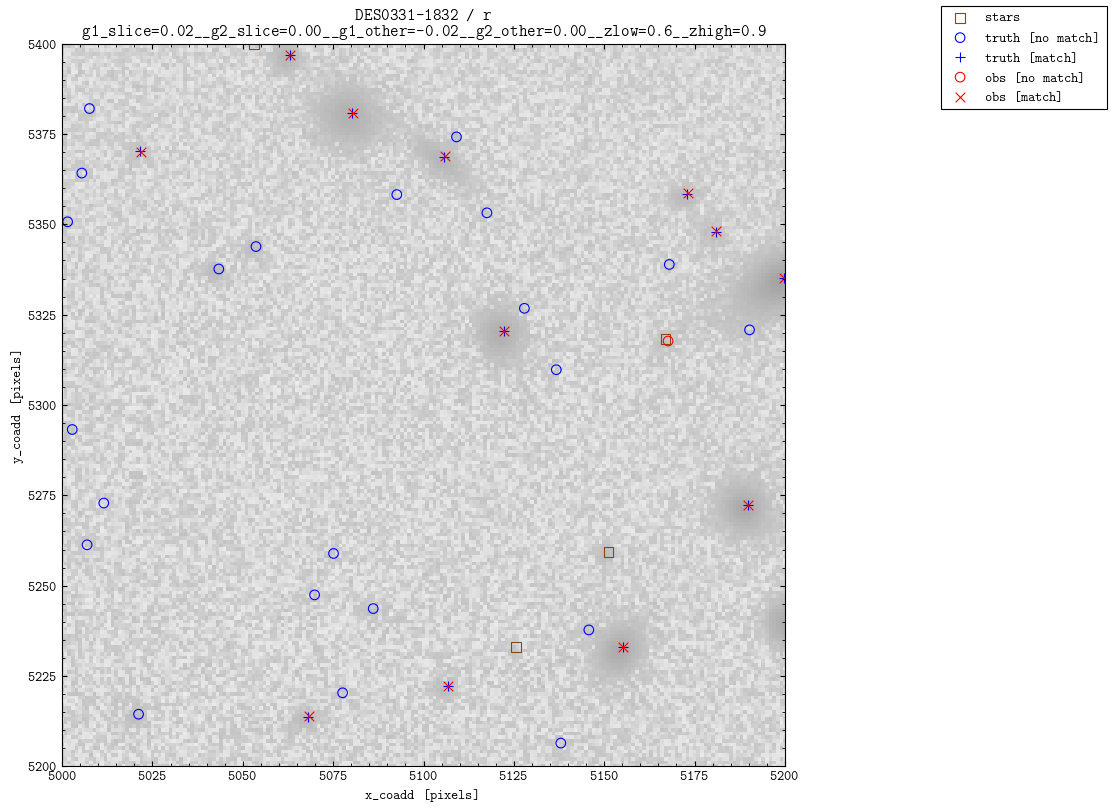

In [47]:
_size = 200
xmin = 5000
xmax = xmin + _size
ymin = 5200
ymax = ymin + _size

query_radius_pixels = np.rad2deg(query_radius) * 60 * 60 / 0.263

star_x, star_y = wcs.toImage(
    star_table["ra"][:],
    star_table["dec"][:],
    units=galsim.degrees,
)
star_sel = (
    (star_x >= xmin)
    & (star_x < xmax)
    & (star_y >= ymin)
    & (star_y < ymax)
)

true_x, true_y = wcs.toImage(
    truth_points[truth_min_chi2_indices, 0],
    truth_points[truth_min_chi2_indices, 1],
    units=galsim.radians,
)
true_sel = (
    (true_x >= xmin)
    & (true_x < xmax)
    & (true_y >= ymin)
    & (true_y < ymax)
)

all_true_x, all_true_y = wcs.toImage(
    truth_points[truth_unmatched_indices, 0],
    truth_points[truth_unmatched_indices, 1],
    units=galsim.radians,
)
all_true_sel = (
    (all_true_x >= xmin)
    & (all_true_x < xmax)
    & (all_true_y >= ymin)
    & (all_true_y < ymax)
)

all_obs_x, all_obs_y = wcs.toImage(
    observed_points[observed_unmatched_indices, 0],
    observed_points[observed_unmatched_indices, 1],
    units=galsim.radians,
)
all_obs_sel = (
    (all_obs_x >= xmin)
    & (all_obs_x < xmax)
    & (all_obs_y >= ymin)
    & (all_obs_y < ymax)
)

obs_x, obs_y = wcs.toImage(
    observed_points[observed_min_chi2_indices, 0],
    observed_points[observed_min_chi2_indices, 1],
    units=galsim.radians,
)
obs_sel = (
    (obs_x >= xmin)
    & (obs_x < xmax)
    & (obs_y >= ymin)
    & (obs_y < ymax)
)

fig, axs = plt.subplots(1, 1, constrained_layout=True, figsize=(12, 8))

axs.imshow(np.arcsinh(coadd), origin="lower", alpha=0.5)

    
# axs.quiver(
#     true_x,
#     true_y,
#     obs_x - true_x,
#     obs_y - true_y,
#     angles="xy",
#     scale_units="xy",
#     scale=1,
#     headwidth=0,
#     headlength=0,
#     headaxislength=0,
#     color="red",
#     label="match",
# )

axs.scatter(
    star_x[star_sel],
    star_y[star_sel],
    s=48,
    ec="saddlebrown",
    fc="none",
    marker="s",
    label="stars",
)

axs.scatter(
    all_true_x[all_true_sel],
    all_true_y[all_true_sel],
    s=48,
    ec="b",
    fc="none",
    marker="o",
    label="truth [no match]",
)

axs.scatter(
    true_x[true_sel],
    true_y[true_sel],
    # s=1,
    s=48,
    c="b",
    # marker=".",
    marker="+",
    label="truth [match]",
)

axs.scatter(
    all_obs_x[all_obs_sel],
    all_obs_y[all_obs_sel],
    s=48,
    ec="r",
    fc="none",
    marker="o",
    label="obs [no match]",
)

axs.scatter(
    obs_x[obs_sel],
    obs_y[obs_sel],
    # s=1,
    s=48,
    c="r",
    # marker=".",
    marker="x",
    label="obs [match]",
)

axs.set_xlim(xmin, xmax)
axs.set_ylim(ymin, ymax)

axs.set_xlabel("x_coadd [pixels]")
axs.set_ylabel("y_coadd [pixels]")
axs.set_title(f"{tilename.astype(str)} / r\n{shear_step}")

fig.legend(loc="outside right upper")

plt.show()

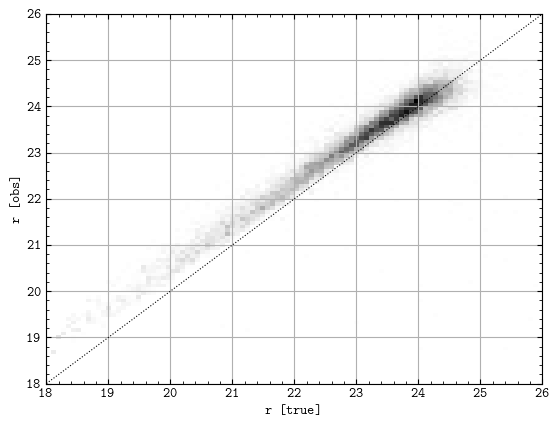

In [48]:
plt.hist2d(
    truth_table["mag_r"][truth_min_chi2_indices],
    30 - 2.5 * np.log10(observed_table["pgauss_band_flux_r"][observed_min_chi2_indices]),
    bins=(np.linspace(18, 26, 101), np.linspace(18, 26, 101)),
)
plt.xlim(18, 26)
plt.ylim(18, 26)
plt.axline((18, 18), (26, 26), ls=":")
plt.grid()
plt.xlabel("r [true]")
plt.ylabel("r [obs]")
plt.show()

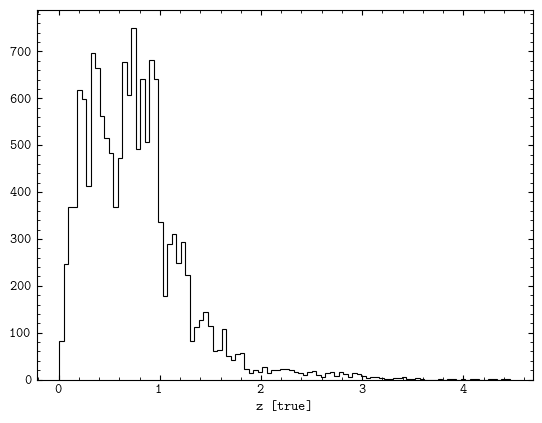

In [49]:
plt.hist(truth_table["photoz"][truth_min_chi2_indices], histtype="step", ec="k", bins=100)
plt.xlabel("z [true]")
plt.show()

In [51]:
import tomography

In [52]:
redshift_base = "/global/cfs/cdirs/des/y6-redshift/imsim_400Tile/fidbin_S005/"
redshift_catalogs = {
    shear_step: os.path.join(
        redshift_base,
        f"{shear_step}_sompz_unblind_fidbin.h5"
    )
    for shear_step in shear_steps
}
redshift_hf = {
    shear_step: h5py.File(redshift_catalog, mode="r")
    for shear_step, redshift_catalog in redshift_catalogs.items()
}

In [53]:
bhat = tomography.get_tomography(
    imsim_hf[shear_step],
    redshift_hf[shear_step],
    "noshear",
)

In [54]:
tomo_colors = {
    0: "blue",
    1: "gold",
    2: "green",
    3: "red",
}
tomographic_bins = [0, 1, 2, 3]

In [55]:
# from https://github.com/beckermr/des-y6-analysis/blob/main/2024_10_21_fgmodels/des_y6_nz_modeling.py
def sompz_integral(y, x, low, high):
    low = np.minimum(x[-1], np.maximum(low, x[0]))
    high = np.minimum(x[-1], np.maximum(high, x[0]))
    low_ind = np.digitize(low, x)
    # for the lower index we do not use right=True, but
    # we still want to clip to a valid index of x
    low_ind = np.minimum(low_ind, x.shape[0] - 1)
    high_ind = np.digitize(high, x, right=True)
    dx = x[1:] - x[:-1]

    # high point not in same bin as low point
    not_in_single_bin = high_ind > low_ind

    # fractional bit on the left
    ileft = np.where(
        not_in_single_bin,
        (y[low_ind - 1] + y[low_ind])
        / 2.0
        * (1.0 - (low - x[low_ind - 1]) / dx[low_ind - 1])
        * dx[low_ind - 1],
        (y[low_ind - 1] + y[low_ind]) / 2.0 * (high - low),
    )

    # fractional bit on the right
    iright = np.where(
        not_in_single_bin,
        (y[high_ind - 1] + y[high_ind]) / 2.0 * (high - x[high_ind - 1]),
        0.0,
    )

    # central bits
    yint = (y[1:] + y[:-1]) / 2.0 * dx
    yind = np.arange(yint.shape[0])
    msk = (yind >= low_ind) & (yind < high_ind - 1)
    icen = np.where(
        np.any(msk),
        np.sum(
            np.where(
                msk,
                yint,
                np.zeros_like(yint),
            )
        ),
        0.0,
    )

    return ileft + icen + iright

In [56]:
zbinsc = redshift_hf[shear_step]["sompz"]["pzdata_weighted_S005"]["zbinsc"][:]

zs = np.concatenate([[0.0], zbinsc])

nzs = {}
for tomographic_bin in tomographic_bins:
    _nz =redshift_hf[shear_step]["sompz"]["pzdata_weighted_S005"][f"bin{tomographic_bin}"][:]
    _nz = np.concatenate([[0.0], _nz])
    nzs[tomographic_bin] = _nz / np.asarray(sompz_integral(_nz, zs, 0, 6.0))
    
nzs[-1] = (nzs[0] + nzs[1] + nzs[2] + nzs[3]) / 4

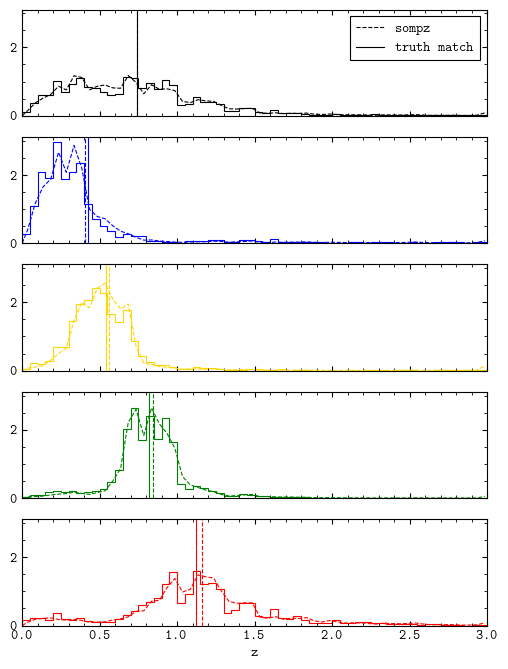

In [57]:
fig, axs = plt.subplots(len(tomographic_bins) + 1, 1, figsize=(6, 8), sharex=True, sharey=True)

nbins = 60
edges = np.linspace(0, 3, nbins + 1)
centers = (edges[:-1] + edges[1:]) / 2


axs[0].axvline(
    np.average(zs, weights=nzs[-1]),
    c="k",
    ls="--",
)
axs[0].plot(
    zs,
    nzs[-1],
    c="k",
    ls="--",
    label="sompz"
)

_nz, _ = np.histogram(truth_table["photoz"][truth_min_chi2_indices], bins=edges)
_nz = _nz / np.diff(edges) / np.sum(_nz)
# axs[0].hist(truth_table["photoz"][truth_min_chi2_indices], histtype="step", ec="k", bins=edges, density=True, label="truth match")
axs[0].axvline(
    np.average(centers, weights=_nz),
    c="k",
)
axs[0].stairs(_nz, edges=edges, ec="k", label="truth match")

axs[0].legend(loc="upper right")


for i in tomographic_bins:
    axs[i + 1].axvline(
        np.average(zs, weights=nzs[i]),
        c=tomo_colors[i],
        ls="--",
    )
    axs[i + 1].plot(
        zs,
        nzs[i],
        c=tomo_colors[i],
        ls="--",
    )
    
    bhat_sel = bhat[in_tile][observed_min_chi2_indices] == i
    
    _nz, _ = np.histogram(truth_table["photoz"][truth_min_chi2_indices[bhat_sel]], bins=edges)
    _nz = _nz / np.diff(edges) / np.sum(_nz)
    axs[i + 1].axvline(
        np.average(centers, weights=_nz),
        c=tomo_colors[i],
    )
    
    # axs[i + 1].hist(truth_table["photoz"][truth_min_chi2_indices[bhat_sel]], histtype="step", ec=tomo_colors[i], bins=edges, density=True)
    axs[i + 1].stairs(_nz, edges=edges, ec=tomo_colors[i])

axs[-1].set_xlim(0, 3)
axs[-1].set_xlabel("z")

plt.show()

In [58]:
print("mean(truth) - mean(sompz)")
for i in tomographic_bins:
    bhat_sel = bhat[in_tile][observed_min_chi2_indices] == i
    _nz, _ = np.histogram(truth_table["photoz"][truth_min_chi2_indices[bhat_sel]], bins=edges)
    _nz = _nz / np.diff(edges) / np.sum(_nz)
    
    mean_z_truth = np.average(centers, weights=_nz)
    
    mean_z_sompz = np.average(zs, weights=nzs[i])
    
    print(mean_z_truth - mean_z_sompz)

mean(truth) - mean(sompz)
0.02084775055911864
-0.015508932190975155
-0.021524511780878774
-0.03910534123274312
